In [1]:
import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from mpl_toolkits.axes_grid1 import ImageGrid

import torch
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
from gradcam.utils.image import show_cam_on_image
from gradcam.multimae_cam import MultiMAECAM
from gradcam.utils.model_targets import MultiMAESemanticSegmentationTarget

from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.plot_utils import plot_predictions
from multimae.models.criterion import MaskedCrossEntropyLoss, MaskedMSELoss, MaskedL1Loss

from functools import partial
from multimae.models.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.models.output_adapters import SpatialOutputAdapter
from pipelines.utils.data_utils import get_semseg_metadata
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from multimae.utils.datasets import build_multimae_pretraining_dataset
from multimae.parsers.pretrain_multimae import get_args
from multimae.utils.model_builder import create_model
from multimae.utils.train_utils import normalize_depth

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import sys
sys.argv = ['']

In [3]:
model_name = "only-gate-mask-rgb_unmask-depth-loss"

models = {
    "unmask-semseg-loss": "03-11-17-16-39",
    "gate-half-depth-semseg": "03-11-23-14-17",
    "no-standard-depth": "03-12-11-46-23",
    "only-gate-mask-rgb_unmask-depth-loss": "03-12-18-08-15",
    "depth-semseg": "03-12-23-04-05",
    "fine-semseg": "03-13-11-59-42"
}

In [4]:
DOMAIN_CONF = {
    'rgb': {
        'channels': 3,
        'stride_level': 1,
        'input_adapter': partial(PatchedInputAdapter, num_channels=3),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3),
        'loss': MaskedMSELoss,
    },
    'depth': {
        'channels': 1,
        'stride_level': 1,
        'input_adapter': partial(PatchedInputAdapter, num_channels=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=1),
        'loss': MaskedL1Loss,
    },
    'semseg': {
        'num_classes': 133,
        'stride_level': 4,
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=133),
        'loss': partial(MaskedCrossEntropyLoss, label_smoothing=0.0),
    },
}

In [5]:
flightmare_path = Path(os.environ["FLIGHTMARE_PATH"])
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"

device = torch.device('cuda')
pretrained_model_path = multimae_path / f"results/pretrain/{models[model_name]}/checkpoint-299.pth"
ckpt = torch.load(pretrained_model_path, map_location='cpu')

In [6]:
args = ckpt["args"]
args.semseg_stride_level = 4

input_adapters = {
    domain: DOMAIN_CONF[domain]['input_adapter'](
        stride_level=DOMAIN_CONF[domain]['stride_level'],
        patch_size_full=args.patch_size,
    )
    for domain in args.in_domains
}

output_adapters = {
    domain: DOMAIN_CONF[domain]['output_adapter'](
        stride_level=DOMAIN_CONF[domain]['stride_level'],
        patch_size_full=args.patch_size,
        dim_tokens=args.decoder_dim,
        depth=args.decoder_depth,
        num_heads=args.decoder_num_heads,
        use_task_queries=args.decoder_use_task_queries,
        task=domain,
        context_tasks=list(args.in_domains),
        use_xattn=args.decoder_use_xattn
    )
    for domain in args.out_domains
}

# Add normalized pixel output adapter if specified
if args.extra_norm_pix_loss:
    output_adapters['norm_rgb'] = DOMAIN_CONF['rgb']['output_adapter'](
        stride_level=DOMAIN_CONF['rgb']['stride_level'],
        patch_size_full=args.patch_size,
        dim_tokens=args.decoder_dim,
        depth=args.decoder_depth,
        num_heads=args.decoder_num_heads,
        use_task_queries=args.decoder_use_task_queries,
        task='rgb',
        context_tasks=list(args.in_domains),
        use_xattn=args.decoder_use_xattn
    )

model = create_model(
    args.model,
    pretrained=args.pretrained,
    input_adapters=input_adapters,
    output_adapters=output_adapters,
    num_global_tokens=args.num_global_tokens,
    drop_path_rate=args.drop_path
) 

Successfully load the pretrained weights from torch hub.


In [7]:
model.load_state_dict(ckpt['model'], strict=True)   

<All keys matched successfully>

### load checkpoints

In [8]:
model.to("cuda")
model.eval()

MultiMAE(
  (input_adapters): ModuleDict(
    (rgb): PatchedInputAdapter(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (depth): PatchedInputAdapter(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
    )
  )
  (output_adapters): ModuleDict(
    (rgb): SpatialOutputAdapter(
      (task_embeddings): ParameterDict(
          (depth): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
          (rgb): Parameter containing: [torch.cuda.FloatTensor of size 1x1x256 (GPU 0)]
      )
      (decoder): CrossAttention(
        (q): Linear(in_features=256, out_features=256, bias=True)
        (kv): Linear(in_features=256, out_features=512, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (context_norm): LayerNorm((256,), eps=1e-06, elementwise_affine=True)
      (query_norm): LayerNo

In [9]:
print(model.output_adapters.keys())

odict_keys(['rgb', 'depth', 'semseg', 'norm_rgb'])


In [10]:
# prefix = "001405"
# sample_rgb = multimae_path / f"datasets/test/val/rgb/data/{prefix}.png"
# sample_depth = multimae_path / f"datasets/test/val/depth/data/{prefix}.png"
# sample_semseg = multimae_path / f"datasets/test/val/semseg/data/{prefix}.png"

# image = cv2.imread(str(sample_rgb))
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image_float = torch.from_numpy(image).float().permute(2, 0, 1) / 255.0
# c, h, w = image_float.shape

# image_float = TF.center_crop(image_float, min([h, w]))
# image_float = TF.resize(image_float, 224)
# image_float = image_float.permute(1, 2, 0).numpy().astype(np.float32)
# print(image_float.shape)

# image = Image.fromarray(image)

# semseg = cv2.imread(str(sample_semseg))
# print(semseg.shape)
# depth = cv2.imread(str(sample_depth)) / 2 ** 16
# print(depth.shape)

# fig, axs = plt.subplots(1, 3)
# axs[0].imshow(image)
# axs[0].axis('off')

# axs[1].imshow(semseg * 80)
# axs[1].axis('off')

# axs[2].imshow(depth)
# axs[2].axis('off')

In [11]:
# # Pre-process RGB, depth and semseg to the MultiMAE input format
# input_dict = {
#     "rgb": np.expand_dims(image, [0, -1]),
#     "depth": np.expand_dims(depth[:, :, 0], [0, -2, -1]),
#     "semseg": np.expand_dims(semseg[:, :, 0], [0, 3, 4])
# }

# print(input_dict["rgb"].shape)
# print(input_dict["depth"].shape)
# print(input_dict["semseg"].shape)

# processed_inputs = preprocess_multimae_inputs_in_batch(input_dict, batch_axis=True)
    
# # To GPU
# processed_inputs = {k: v.squeeze(-1).to("cuda") for k,v in processed_inputs.items()}

# print(processed_inputs["rgb"].shape)
# print(processed_inputs["depth"].shape)
# print(processed_inputs["semseg"].shape)

# # processed_inputs["depth"] = normalize_depth(processed_inputs["depth"])

# inputs = {k: processed_inputs[k] for k in args.in_domains}

In [12]:
seed = 7
torch.manual_seed(seed) # change seed to resample new mask
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True

In [13]:
# configure for detectron dataset (for prediection)
eval_data_path = multimae_path / "datasets/test/val"
metadata = get_semseg_metadata(eval_data_path)

In [14]:
args.eval_data_path = str(eval_data_path)
dataset_val = build_multimae_pretraining_dataset(args, args.eval_data_path)
sampler_val = torch.utils.data.RandomSampler(dataset_val)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, sampler=sampler_val,
    batch_size=1,
    num_workers=args.num_workers,
    pin_memory=args.pin_mem,
    drop_last=True,
)

In [15]:
inputs = iter(data_loader_val).next()[0]

In [16]:
if model_name != "no-standard-depth" and "depth" in inputs:
    inputs["depth"] = normalize_depth(inputs["depth"])
inputs = {k: v.to("cuda") for k,v in inputs.items()}

In [17]:
print(inputs["depth"].min())
print(inputs["depth"].max())

tensor(-0.8606, device='cuda:0')
tensor(5.2839, device='cuda:0')


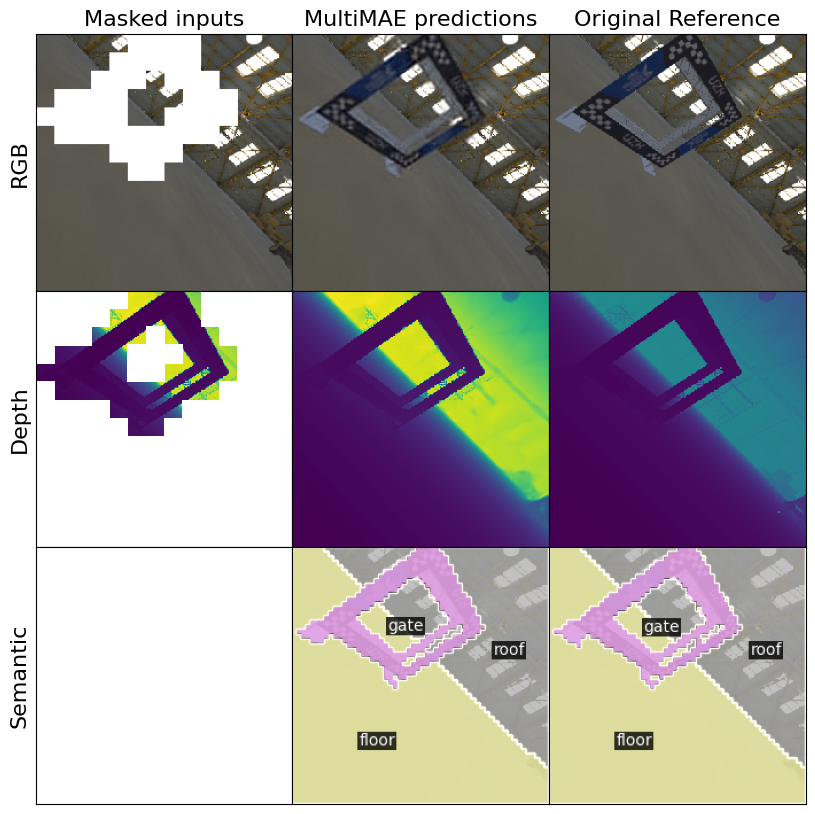

In [18]:
preds, masks = model(
    inputs, 
    num_encoded_tokens=196, 
    alphas=args.alphas, 
    sample_tasks_uniformly=args.sample_tasks_uniformly,
    mask_type=args.mask_type,
    masked_rgb_gate_only=True,
    semseg_gt=inputs["semseg"],
    in_domains=args.in_domains,
    semseg_stride=4
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

for domain in ["rgb", "depth", "semseg"]:
    if domain not in masks:
        masks[domain] = torch.ones_like(list(masks.values())[0])

res = plot_predictions(inputs, preds, masks, metadata=metadata)

In [19]:
print(preds["depth"].min())
print(preds["depth"].max())

tensor(-1.7259)
tensor(2.6348)


In [20]:
def plot_vis(res, image_float, grayscale_cam):
    fig = plt.figure(figsize=(10, 10))
    axs = ImageGrid(fig, 111, nrows_ncols=(2, 3), axes_pad=0)

    axs[0].imshow(res["rgb_input"])
    axs[0].axis('off')
    axs[0].set_title("RGB")

    axs[1].imshow(res["depth_input"] if res["depth_input"] is not None else res["rgb_input"])
    axs[1].axis('off')
    axs[1].set_title("Depth")

    axs[2].imshow(res["semseg_input"] if res["semseg_input"] is not None else res["rgb_input"])
    axs[2].axis('off')
    axs[2].set_title("Semseg")

    cam_rgb = show_cam_on_image(image_float, grayscale_cam[0, :, :], use_rgb=True)
    axs[3].imshow(cam_rgb)
    axs[3].axis('off')

    axs[4].imshow(cam_rgb)
    axs[4].axis('off')

    axs[5].imshow(cam_rgb)
    axs[5].axis('off')

In [21]:
target_layers = [model.encoder[-1].norm1]
cam = MultiMAECAM(model=model, target_layers=target_layers, use_cuda=True)

gate_class_id = 3
gate_mask_semseg_gt = torch.zeros_like(inputs["semseg"])
gate_mask_semseg_gt[inputs["semseg"] == gate_class_id] = 1

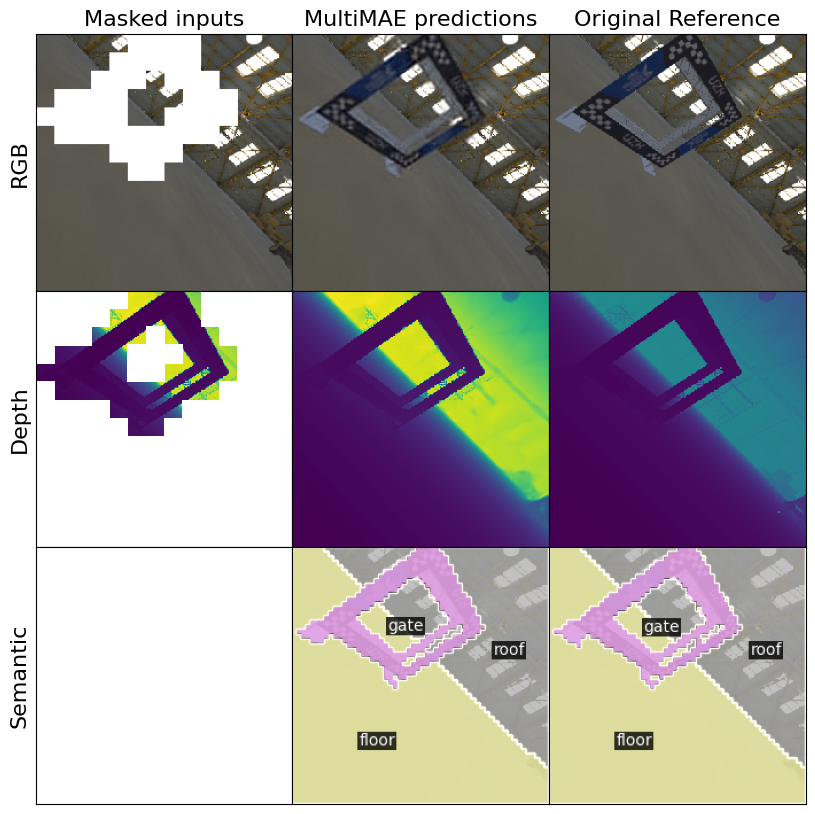

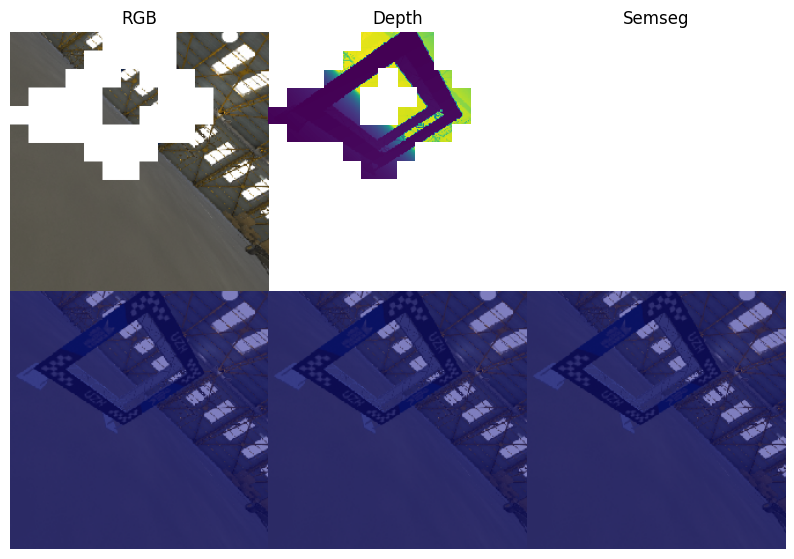

In [22]:
targets = {
    "rgb": MaskedMSELoss(),
    "depth": MaskedL1Loss(),
    "semseg": MultiMAESemanticSegmentationTarget(gate_class_id, gate_mask_semseg_gt)
}

targets = {domain: target for domain, target in targets.items() if domain in args.in_domains}

preds, task_masks, all_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    num_encoded_tokens=196, 
    mask_type="gate-oriented", 
    semseg_gt=inputs["semseg"],
    masked_rgb_gate_only=True,
    in_domains=args.in_domains)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

all_res = plot_predictions(inputs, preds, masks, show_img=True, metadata=metadata)
image_float = all_res["rgb_gt"].numpy().astype(np.float32)
plot_vis(all_res, image_float, all_grayscale_cam)

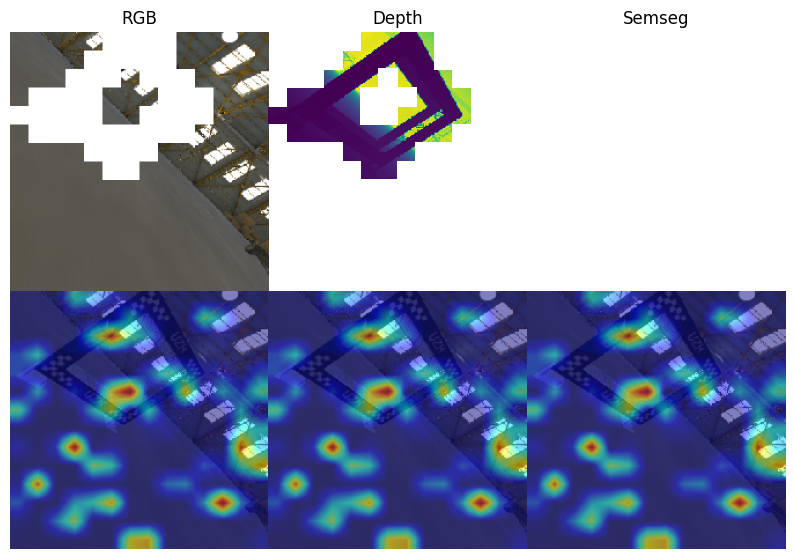

In [23]:
targets = {
    "rgb": MaskedMSELoss()
}
preds, task_masks, rgb_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

rgb_res = plot_predictions(inputs, preds, masks, show_img=False, metadata=metadata)
plot_vis(rgb_res, image_float, rgb_grayscale_cam)

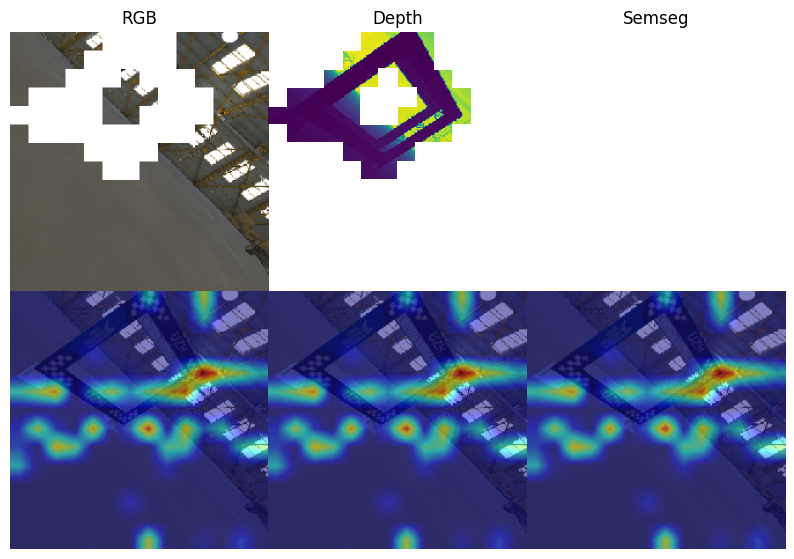

In [24]:
if "depth" in args.in_domains:
    targets = {
        "depth": MaskedL1Loss(),
    }
    preds, task_masks, depth_grayscale_cam = cam(
        input_tensor=inputs, 
        targets=targets, 
        # inputs for multimae preditions
        num_encoded_tokens=196, 
        mask_inputs=True,
        task_masks=task_masks)

    preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
    masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

    depth_res = plot_predictions(inputs, preds, masks, show_img=False, metadata=metadata)
    plot_vis(depth_res, image_float, depth_grayscale_cam)

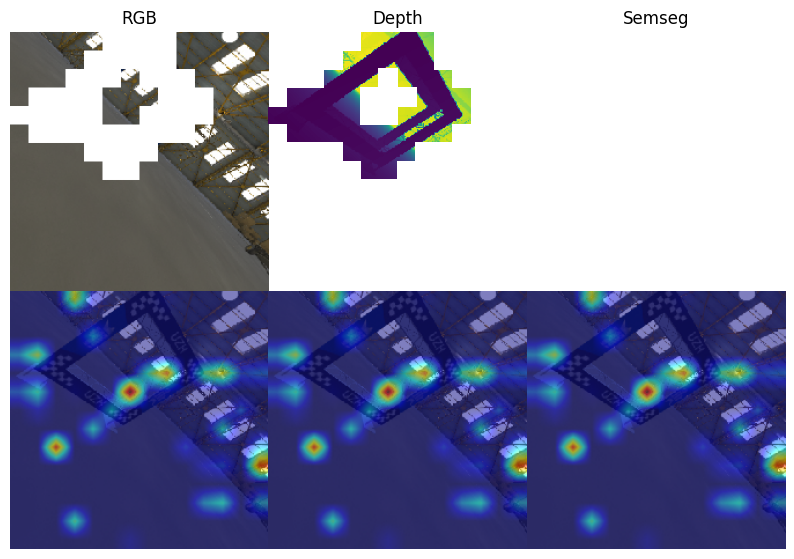

In [25]:
targets = {
    "semseg": MultiMAESemanticSegmentationTarget(gate_class_id, gate_mask_semseg_gt)
}
preds, task_masks, semseg_grayscale_cam = cam(
    input_tensor=inputs, 
    targets=targets, 
    # inputs for multimae preditions
    num_encoded_tokens=196, 
    mask_inputs=True,
    task_masks=task_masks)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in task_masks.items()}

semseg_res = plot_predictions(inputs, preds, masks, show_img=False, metadata=metadata)
plot_vis(semseg_res, image_float, semseg_grayscale_cam)

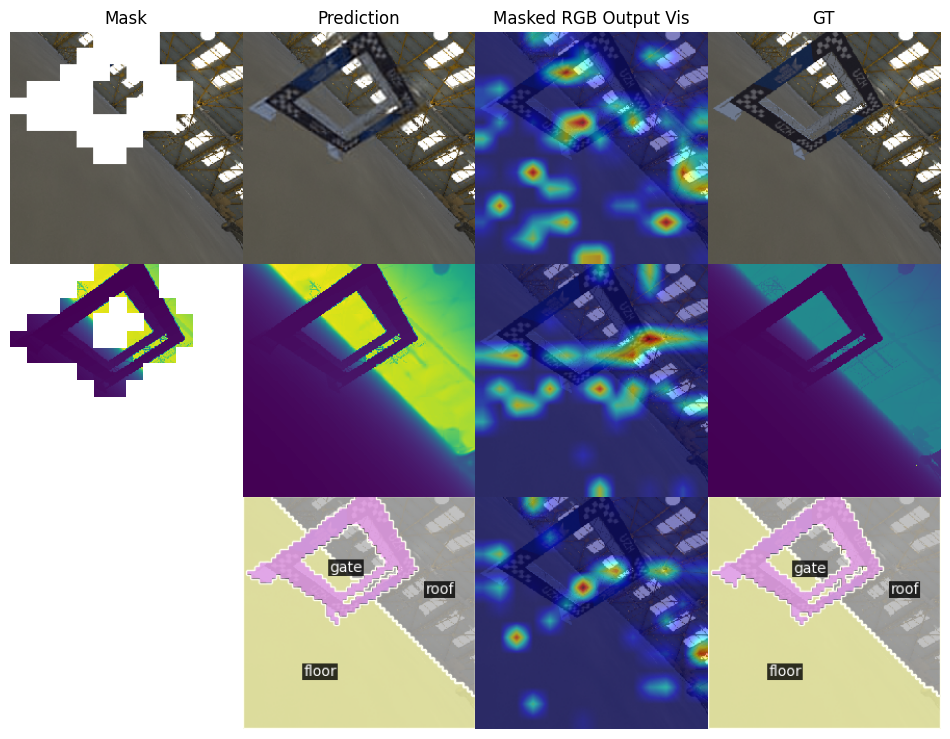

In [26]:
fig = plt.figure(figsize=(12, 12))
axs = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0)

axs[0].imshow(all_res["rgb_input"])
axs[0].axis('off')
axs[0].set_title("Mask")
axs[0].set_ylabel("RGB")

axs[1].imshow(all_res["rgb_pred"])
axs[1].axis('off')
axs[1].set_title("Prediction")

cam_rgb = show_cam_on_image(image_float, rgb_grayscale_cam[0, :, :], use_rgb=True)
axs[2].imshow(cam_rgb)
axs[2].axis('off')
axs[2].set_title("Masked RGB Output Vis")

axs[3].imshow(all_res["rgb_gt"])
axs[3].axis('off')
axs[3].set_title("GT")

if "depth" in args.in_domains:
    axs[4].imshow(all_res["depth_input"])
    axs[4].axis('off')
    axs[4].set_ylabel("Depth")

    axs[5].imshow(all_res["depth_pred"])
    axs[5].axis('off')

    cam_depth = show_cam_on_image(image_float, depth_grayscale_cam[0, :, :], use_rgb=True)
    axs[6].imshow(cam_depth)
    axs[6].axis('off')

    axs[7].imshow(all_res["depth_gt"])
    axs[7].axis('off')

axs[8].imshow(all_res["semseg_input"])
axs[8].axis('off')
axs[8].set_ylabel("Semseg")

axs[9].imshow(all_res["semseg_pred"])
axs[9].axis('off')

cam_semseg = show_cam_on_image(image_float, semseg_grayscale_cam[0, :, :], use_rgb=True)
axs[10].imshow(cam_semseg)
axs[10].axis('off')

axs[11].imshow(all_res["semseg_gt"])
axs[11].axis('off')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])